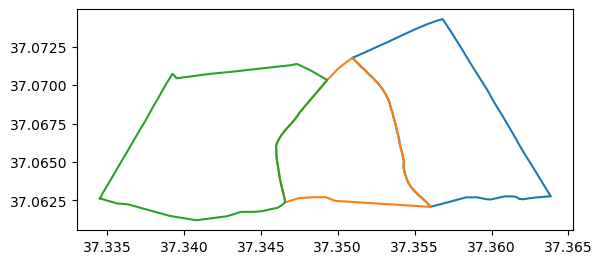

In [29]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from random import choices
from trial_1 import Building
from trial_1 import Area
from shapely.geometry import Polygon
from shapely.geometry import box

# defines a function which imports multiple areas
def import_areas(addresses):
    areas = []
    areas_gdf = []
    for address in addresses:
        # loads the area as a geodataframe
        area_gdf = ox.geocode_to_gdf(address)
        areas_gdf.append(area_gdf)

        # extracts the area id, name and addresstype
        area_id = area_gdf.loc[0, 'osm_id']
        geometry = area_gdf.loc[0, 'geometry']
        name = area_gdf.loc[0, 'name']
        address = address
        addresstype = area_gdf.loc[0, 'addresstype']

        minx = area_gdf.loc[0, 'bbox_west']
        miny = area_gdf.loc[0, 'bbox_south']
        maxx = area_gdf.loc[0, 'bbox_east']
        maxy = area_gdf.loc[0, 'bbox_north']
        bbox = box(minx, miny, maxx, maxy)

        # creates an area object and appends it to the list
        area = Area(area_id, geometry, bbox, name, address, addresstype)
        areas.append(area)
    return areas, areas_gdf

addresses = ['Sarıgüllük Mahallesi', 'Gazi Mah., Gaziantep', 'Pancarlı Mahallesi']
areas, areas_gdf = import_areas(addresses)

# print(areas[0].geometry.type)
# print(areas_gdf)
# print(areas[0].name, areas[0].area_id, areas[0].addresstype)

fig, ax = plt.subplots()
ax.set_aspect('equal')

for a in areas:
    # Extract the exterior boundary of the area geometry
    polygon = a.geometry.exterior

    # Plot the exterior boundary using Matplotlib
    x, y = polygon.xy
    ax.plot(x, y)  # You can set a specific color

plt.show()

In [30]:
# defines a function which imports all buildings in an area
def import_buildings(area):
    # importing osm location
    geometry = area.geometry
    buildings = ox.features.features_from_polygon(geometry, tags={'building': True})

    # creating object for each building
    bld_lst = []
    for i in buildings.index:
        id = i[1]
        geo = buildings.loc[i, 'geometry']
        center_point = geo.centroid
        bld_function = buildings.loc[i, 'building']

        bld = Building(id, geo, center_point, bld_function)
        bld_lst.append(bld)
        area.add_building(bld)
    return bld_lst, area

for a in areas:
    buildings, area = import_buildings(a)
    print(len(a.buildings))

407
295
428


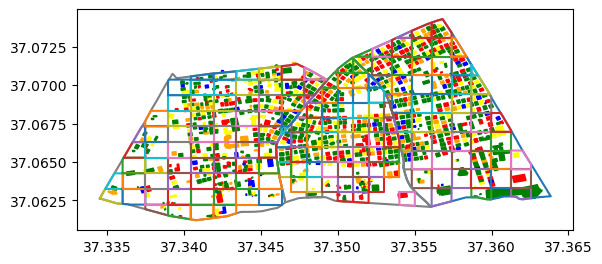

In [31]:
import numpy as np
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as mpl_polygon
from trial_1 import Sub_Area
from trial_1 import Area

# defines a function which generates sub_areas by dividing the boundary of all combined buildings in cells, x_steps = n of cells in x dir, y_steps = n of cells in y dir, and associating buildings with sub_areas
def generate_sub_areas(area, buildings, x_steps, y_steps):
    # set bounds of graph to the bounds of center points
    xmin, ymin, xmax, ymax = area.bbox.bounds
    x_range = xmax - xmin
    y_range = ymax - ymin

    # set stepsize
    width = x_range / x_steps
    height = y_range / y_steps

    # create cols and rows based on bounds and stepsize
    cols = list(np.arange(xmin, xmax + width, width))
    rows = list(np.arange(ymin, ymax + height, height))

    # sort the list of buildings objects based on x coordinates, then y coordinates
    sorted_blds = sorted(buildings, key=lambda x: (x.center_point.x, x.center_point.y))

    # create cells and plot to graph, add buildings to subarea classes
    sub_areas = []
    i = 0
    j = 0
    for x in cols[:-1]:
        # while the buildings have x values in the range of this column, add them to a list
        filt_blds = []
        while (i < len(sorted_blds)) and (sorted_blds[i].center_point.x >= x) and (sorted_blds[i].center_point.x < (x+width)): 
            filt_blds.append(sorted_blds[i])
            filt_blds = sorted(filt_blds, key=lambda x: (x.center_point.y))
            i += 1
            
        for y in rows[:-1]:
            # create a cell, sub_area object, and associate the cell with the object
            polygon = Polygon([(x,y), (x+width, y), (x+width, y+height), (x, y+height)])
            sub_area = Sub_Area(j, polygon)
            
            # while the buildings in that column have y values in the range of this row, add them to the cell object 
            while (len(filt_blds) > 0) and (filt_blds[0].center_point.y >= y) and (filt_blds[0].center_point.y < (y+height)):
                sub_area.add_building(filt_blds.pop(0))

            # only add the sub_area if it has buildings in it
            if sub_area.buildings != []:
                sub_areas.append(sub_area)
            
                # add the sub_areas to the area
                area.add_sub_area(sub_area)

                # crop the geometry of the sub_area with the are geometry
                sub_area.crop_geometry()

                j += 1           
    return sub_areas

# create the sub_areas for each area
for a in areas:
    generate_sub_areas(a, a.buildings, 10, 10)

# defines a function which plots the geometry of the areas, sub_areas and buildings
def show_geometry(areas):
    # create empty graph and plot sub_area geometry to graph
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    for a in areas:
        # Plot the area exterior boundary
        x, y = a.geometry.exterior.xy
        ax.plot(x, y)  # You can set a specific color

        # plot the sub_area geometry        
        for s in a.sub_areas:
            ax.plot(*s.geometry.exterior.xy)
        
        # plot the building geometry
        # save each building geometry attribute in a list
        geos = [o.geometry for o in a.buildings]

        # choices of different colours with corresponding weights
        population = ['green', 'blue', 'yellow', 'orange', 'red']
        weights = [0.45, 0.05, 0.15, 0.12, 0.23]

        # for every geometry choose a colour, fill the geometry and plot to graph
        for g in geos:
            c = choices(population, weights)[0]
            x, y = g.exterior.xy
            ax.fill(x, y, color = c)

    # Display the plot
    plt.show()

# show the geometry for each area, sub_area and building
show_geometry(areas)

In [32]:
def allocate_teams_to_areas(areas, sector_n_heavy_teams, sector_n_med_teams, sector_n_light_teams):
    # define the number of people per team
    heavy_n_people = 24
    medium_n_people = 12
    light_n_people = 6

    # calculate the total number of people required
    total_people = heavy_n_people * sector_n_heavy_teams + medium_n_people * sector_n_med_teams + light_n_people * sector_n_light_teams
    total_priority = 0
    for a in areas:
        total_priority += a.priority_weight
    # calculate the number of people required per priority weight
    people_per_priority = total_people / total_priority

    # calculate the number of people required per area
    for a in areas:
        a.people_requirement = a.priority_weight * people_per_priority

    # sort the areas by people requirement
    sorted_areas = sorted(areas, key=lambda x: (x.people_requirement), reverse=True)

    # reset allocation of teams
    for a in areas:
        a.heavy_teams = 0
        a.med_teams = 0
        a.light_teams = 0

    # allocate teams to areas
    while sector_n_heavy_teams > 0 or sector_n_med_teams > 0 or sector_n_light_teams > 0:
        if sector_n_heavy_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].heavy_teams += 1
            sector_n_heavy_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= heavy_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_med_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].med_teams += 1
            sector_n_med_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= medium_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
        elif sector_n_light_teams > 0:
            # allocate team to the area with highest people requirement
            sorted_areas[0].light_teams += 1
            sector_n_light_teams -= 1
            # edit the people requirement of the area and resort the list
            sorted_areas[0].people_requirement -= light_n_people
            sorted_areas = sorted(sorted_areas, key=lambda x: (x.people_requirement), reverse=True)
    
# allocate teams to areas based of input of number of teams (heavy, med, light) per sector
allocate_teams_to_areas(areas, 2, 1, 1)
print([[o.heavy_teams, o.med_teams, o.light_teams] for o in areas])


[[0, 1, 1], [1, 0, 0], [1, 0, 0]]


In [36]:
from trial_1 import Team
from trial_1 import Sub_Team
from trial_1 import Team_Member
import random

# defines a function which creates team, sub-team and team_member objects based on a number of heavy, medium and light teams in an area
def set_teams(heavy, med, light):
    # initialise amount of teams to be distributed in sector
    n_heavy = heavy
    n_med = med
    n_light = light

    # create all objects in sector and link them
    teams = []
    team_id = 0
    sub_team_id = 0
    team_member_id = 0

    # create heavy teams, subteams and teammembers
    for i in range(n_heavy):
        team = Team(team_id, 'heavy')
        for j in range(4):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id, random.randint(5, 10))
                sub_team.add_team_member(team_member)
                team_member_id += 1
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1

    # create medium teams, subteams and teammembers
    for i in range(n_med):
        team = Team(team_id, 'medium')
        for j in range(2):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id, random.randint(3, 9))
                sub_team.add_team_member(team_member)
                team_member_id += 1
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
        
    # create light teams, subteams and teammembers
    for i in range(n_light):
        team = Team(team_id, 'light')
        for j in range(1):
            sub_team = Sub_Team(sub_team_id)
            for k in range(6):
                team_member = Team_Member(team_member_id, random.randint(1, 8))
                sub_team.add_team_member(team_member)
                team_member_id += 1
            team.add_sub_team(sub_team)
            sub_team_id += 1
        teams.append(team)
        team_id += 1
    return teams

area = areas[0]
sub_areas = area.sub_areas
teams = set_teams(area.heavy_teams, area.med_teams, area.light_teams)

# defines a function which puts all subteams in multiple teams 
def get_sub_teams(teams):
    # access and create sub_teams list
    sub_teams = []
    for tm in teams:
        for stm in tm.sub_teams:
            sub_teams.append(stm)
    return sub_teams

sub_teams = get_sub_teams(teams)
sub_team_members = [o.team_members for o in sub_teams]
print(sub_teams)
print(sub_team_members)

[<trial_1.Sub_Team object at 0x000001A63A066250>, <trial_1.Sub_Team object at 0x000001A639EBECD0>, <trial_1.Sub_Team object at 0x000001A63B1594F0>]
[[<trial_1.Team_Member object at 0x000001A63A066220>, <trial_1.Team_Member object at 0x000001A6306361F0>, <trial_1.Team_Member object at 0x000001A639EBEC10>, <trial_1.Team_Member object at 0x000001A639EBEDF0>, <trial_1.Team_Member object at 0x000001A639EBEAC0>, <trial_1.Team_Member object at 0x000001A639EBECA0>], [<trial_1.Team_Member object at 0x000001A639EBE4F0>, <trial_1.Team_Member object at 0x000001A639EBEC70>, <trial_1.Team_Member object at 0x000001A639EBEFD0>, <trial_1.Team_Member object at 0x000001A639EBE9A0>, <trial_1.Team_Member object at 0x000001A639EBE880>, <trial_1.Team_Member object at 0x000001A639EBEB50>], [<trial_1.Team_Member object at 0x000001A63B1595B0>, <trial_1.Team_Member object at 0x000001A63B1590D0>, <trial_1.Team_Member object at 0x000001A63B159250>, <trial_1.Team_Member object at 0x000001A63B159670>, <trial_1.Team_

In [37]:
# defines a function which allocates sub_teams to sub_areas based on priority weight and competence, at start of allocating
def sort_priority_competence(sub_areas, sub_teams):
    # sorts the sub_areas so that the sub_areas with the highest priority weight are first in the list
    sub_areas = sorted(sub_areas, key=lambda x: (x.priority_weight), reverse=True)

    # sorts the sub_teams so that the sub_teams with the highest competence are first in the list
    sub_teams = sorted(sub_teams, key=lambda x: (x.competence), reverse=True)
    return sub_areas, sub_teams

# sort the sub_areas and sub_teams lists
sub_areas, sub_teams = sort_priority_competence(sub_areas, sub_teams)
print([o.priority_weight for o in sub_areas])
print([o.competence for o in sub_teams])
print(sub_areas)

# defines a function which allocates sub_team(s) to sub_area(s) based on priority weight and competence, works with sub_teams list or single object
def allocate_sub_team(sub_areas, sub_teams):
    rem_sub_areas = sub_areas
    # links the objects of sub_teams to sub_areas and removes the sub_areas that are allocated from the sub_areas list
    if hasattr(sub_teams, '__iter__'):
        for i, o in enumerate(sub_teams):
            o.assign_sub_area(rem_sub_areas.pop(0))
    else:
        sub_teams.assign_sub_area(rem_sub_areas.pop(0))
    return rem_sub_areas

# allocate all teams during start
rem_sub_areas = allocate_sub_team(sub_areas, sub_teams)
print(len(rem_sub_areas))

# allocate a team after the team cleared a sub_area
rem_sub_areas = allocate_sub_team(rem_sub_areas, sub_teams[0])
print(len(rem_sub_areas))
print(len(sub_areas))

# WHY DOES IT KEEP REMOVING ITEMS FROM THE sub_areas LIST, VARIABLES IN A FUNCTION SHOULD BE LOCAL???

[93.0, 89.0, 77.0, 76.5, 75.0, 71.0, 71.0, 68.0, 65.33333333333333, 64.0, 63.0, 62.666666666666664, 62.5, 61.61538461538461, 59.72727272727273, 58.8, 58.0, 57.916666666666664, 56.333333333333336, 55.5, 52.75, 51.625, 51.333333333333336, 51.0, 50.44444444444444, 50.166666666666664, 49.7, 49.18181818181818, 49.0, 47.0, 47.0, 46.5, 46.5, 46.333333333333336, 44.5, 44.44444444444444, 44.0, 43.5, 43.25, 42.45454545454545, 42.333333333333336, 40.2, 39.888888888888886, 39.5, 38.0, 37.6, 37.333333333333336, 36.333333333333336, 35.833333333333336, 34.25, 33.75, 31.8, 29.3125, 20.0, 15.0, 8.5]
[6.833333333333333, 6.166666666666667, 3.3333333333333335]
[<trial_1.Sub_Area object at 0x000001A63B149280>, <trial_1.Sub_Area object at 0x000001A638A3B430>, <trial_1.Sub_Area object at 0x000001A638A3B5B0>, <trial_1.Sub_Area object at 0x000001A63B1495E0>, <trial_1.Sub_Area object at 0x000001A63B149640>, <trial_1.Sub_Area object at 0x000001A63B149610>, <trial_1.Sub_Area object at 0x000001A63B1496A0>, <trial_

In [ ]:
# allocation of sub_teams in an area to sub_areas phase 2
for s in sub_teams:
    # filter the sub_areas list to only include sub_areas that have not been cleared and that have required actions that the sub_team can perform
    for sa in sub_areas:
        if (sa.required_actions in s.team_members) and (sa.cleared == False):
            s.serveable_sub_areas.append(sa)

all_actions = [o.required_actions for o in sub_areas]
all_combinations = itertools.product()

In [ ]:
"""Hops flask middleware example"""
import sys
import os
from flask import Flask
from PIL import Image
import rhino3dm as rs

# load ghhops-server-py source from this directory
import ghhops_server as hs

# register hops app as middleware
app = Flask(__name__)
hops: hs.HopsFlask = hs.Hops(app)

# flask app can be used for other stuff directly
@app.route("/help")
def help():
    return "Welcome to Grashopper Hops for CPython!"


@app.route("/update", methods=["POST"])
def update():
    return "Update example!"

# component
@hops.component(
    "/imft",
    name="ImportFootprints",
    nickname="IF",
    description="Import Building Footprints",
    outputs=[hs.HopsPoint("Footprints", "F", "List of footprints imported")]
)

def import_footprints():
    c_pts = []
    for geo in geos:
        points = []
        for point in geo.exterior.coords:
            x, y = point
            rh_point = rs.Point3d(x, y, 0)
            points.append(rh_point)
        c_pts.append(points)
    polygon = rs.Curve.CreateControlPointCurve(c_pts)
    return hs.HopsCurve(polygon)

if __name__ == "__main__":
    app.run()